In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

import matplotlib
from pcygni_profile import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time
import pickle
import corner

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)

In [2]:
import tarfile 
#file = tarfile.open(name='figure_4.tar.gz', mode='r')

In [3]:
#file.extractall('./Inclination')

In [4]:
#file.close()

In [5]:
# Grid points in distance and inclination (theta_jn)
XX = np.loadtxt('./Inclination/figure_4/incl_grid_pts.dat.gz')
YY = np.loadtxt('./Inclination/figure_4/dist_grid_pts.dat.gz')

# Posterior PDF values for the marginal distributions shown in Figure 4
gw_Z = np.loadtxt('./Inclination/figure_4/volumetric_marginal_posterior_pdf.dat.gz')
em_Z = np.loadtxt('./Inclination/figure_4/em_dist_prior_marginal_posterior_pdf.dat.gz')

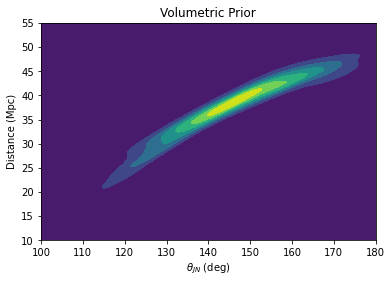

In [6]:
# Plot the posterior corresponding to the GW-only, volumetric prior
plt.contourf(XX, YY, gw_Z)

plt.title('Volumetric Prior')
plt.xlabel(r'$\theta_{JN}$ (deg)')
plt.ylabel('Distance (Mpc)');

In [26]:
ourprior = 1/np.sqrt(2*np.pi*0.4**2)*np.exp(-(YY-43.24)**2/(2*0.4**2))

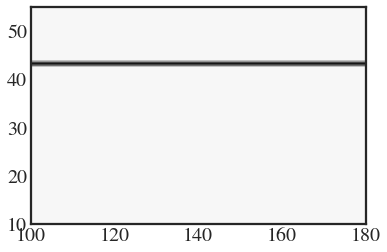

In [27]:
plt.contourf(XX, YY, ourprior)


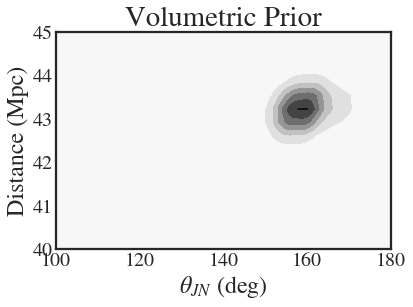

In [28]:
# Plot the posterior corresponding to the GW-only, volumetric prior
plt.contourf(XX, YY, gw_Z*ourprior)

plt.ylim(40,45), plt.ylim(40,45)

plt.title('Volumetric Prior')
plt.xlabel(r'$\theta_{JN}$ (deg)')
plt.ylabel('Distance (Mpc)');

## 1D-distributions

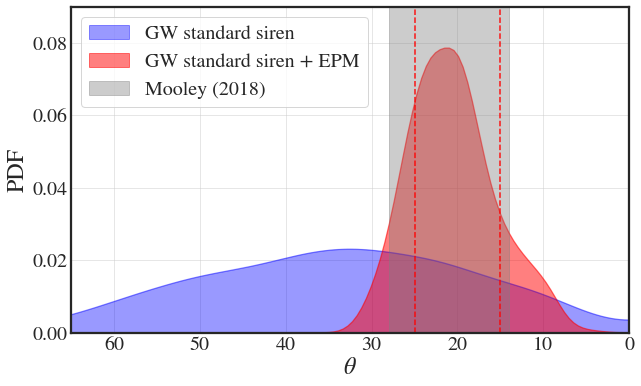

In [34]:
reset_plt(20,24)
plt.figure(figsize=(10,6))
# Extract the 1-D grids for 1-D marginal distribution plots
theta_jns = XX[0, :]
d_theta_jn = theta_jns[1] - theta_jns[0]

dists = YY[:, 0]
d_dist = dists[1] - dists[0]

plt.plot(theta_jns, d_dist*np.sum(gw_Z, axis=0), color='blue', alpha=0.2)
plt.fill_between(theta_jns, d_dist*np.sum(gw_Z, axis=0), label='GW standard siren', color='blue', alpha=0.4)
y = d_dist*np.sum(gw_Z, axis=0)
norm = np.trapz(y, x = theta_jns)
y2 = np.array([np.trapz(y[:i], x = theta_jns[:i]) for i in range(len(theta_jns))])
#low, high = interp1d(y2, theta_jns)(0.169), interp1d(y2, theta_jns)(1-0.169)
#plt.fill_between([low, high], [0, 0], [1, 1], color='blue', alpha=0.1 )
#plt.axvline(interp1d(y2, theta_jns)(0.5), ls='--', color='blue', alpha=0.1)


y = d_dist*np.sum(gw_Z*ourprior, axis=0)
norm = np.trapz(y, x = theta_jns)
plt.plot(theta_jns, y/norm, color='red', alpha=0.2)
plt.fill_between(theta_jns, y/norm, color='red', alpha=0.5, label='GW standard siren + EPM')
#plt.plot(theta_jns, d_dist*np.sum(em_Z, axis=0), label='EM Distance Prior')
plt.xlim(theta_jns[0], theta_jns[-1])
plt.ylim(ymin=0)

plt.xlabel(r'$\theta$')
plt.ylabel('PDF');
plt.ticklabel_format(style='plain')

y2 = np.array([np.trapz(y[:i]/norm, x = theta_jns[:i]) for i in range(len(theta_jns))])
low, high = interp1d(y2, theta_jns)(0.169), interp1d(y2, theta_jns)(1-0.169)
#plt.fill_between([low, high], [0, 0], [1, 1], color='orange', alpha=0.2 )
#plt.axvline(interp1d(y2, theta_jns)(0.5), ls='--', color='orange')
plt.fill_between([180-28, 180-14], [0, 0], [1, 1], color='grey', alpha=0.4, label='Mooley (2018)' )

plt.ylim(0, 0.09), plt.xlim(115, 180)
xticks =  np.array([120, 130, 140, 150, 160, 170, 180])
plt.xticks(xticks, 180-xticks)

plt.axvline(interp1d(y2, theta_jns)(0.169)  , color='red', ls='--', alpha=0.9)
plt.axvline(interp1d(y2, theta_jns)(1-0.169), color='red', ls='--', alpha=0.9)

plt.legend(loc='upper left', frameon=True, fontsize=20); 

#plt.savefig('Pictures/Inclination_prior_3.png', dpi=300)

In [30]:
y2 = np.array([np.trapz(y[:i]/norm, x = theta_jns[:i]) for i in range(len(theta_jns))])

In [31]:
interp1d(y2, theta_jns)(0.169), interp1d(y2, theta_jns)(1-0.169)

(array(155.02599723), array(164.94249135))

In [32]:
interp1d(y2, theta_jns)(0.5)

array(159.58145836)

In [3]:
180-159.6, 180-155, 180-164.8

(20.400000000000006, 25, 15.199999999999989)